In [2]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from statsmodels.stats.proportion import proportion_confint

sns.set(palette='Set2', style='whitegrid', font_scale=1.3)

---

### Задача 1.

Пусть в общей совокупности данных имеется $K$ страт, причем вес страты $k \in \{1, ..., K\}$ равен $w_k$, где $w_1+...+w_K=1$. Пусть также выборка размера $n$ выбрана случайно, то есть вероятность выбрать элемент из страты $k$ равна $w_k$.

Посчитайте $\mathsf{E} \frac{1}{n_k}$ с точностью до $o(1/n^2)$, где $n_k$ &mdash; количество элементов выборки из страты $k$.

*Указание.* Разложите по Тейлору функцию $f(x)=1/x$ в точке $x_0\not=0$.

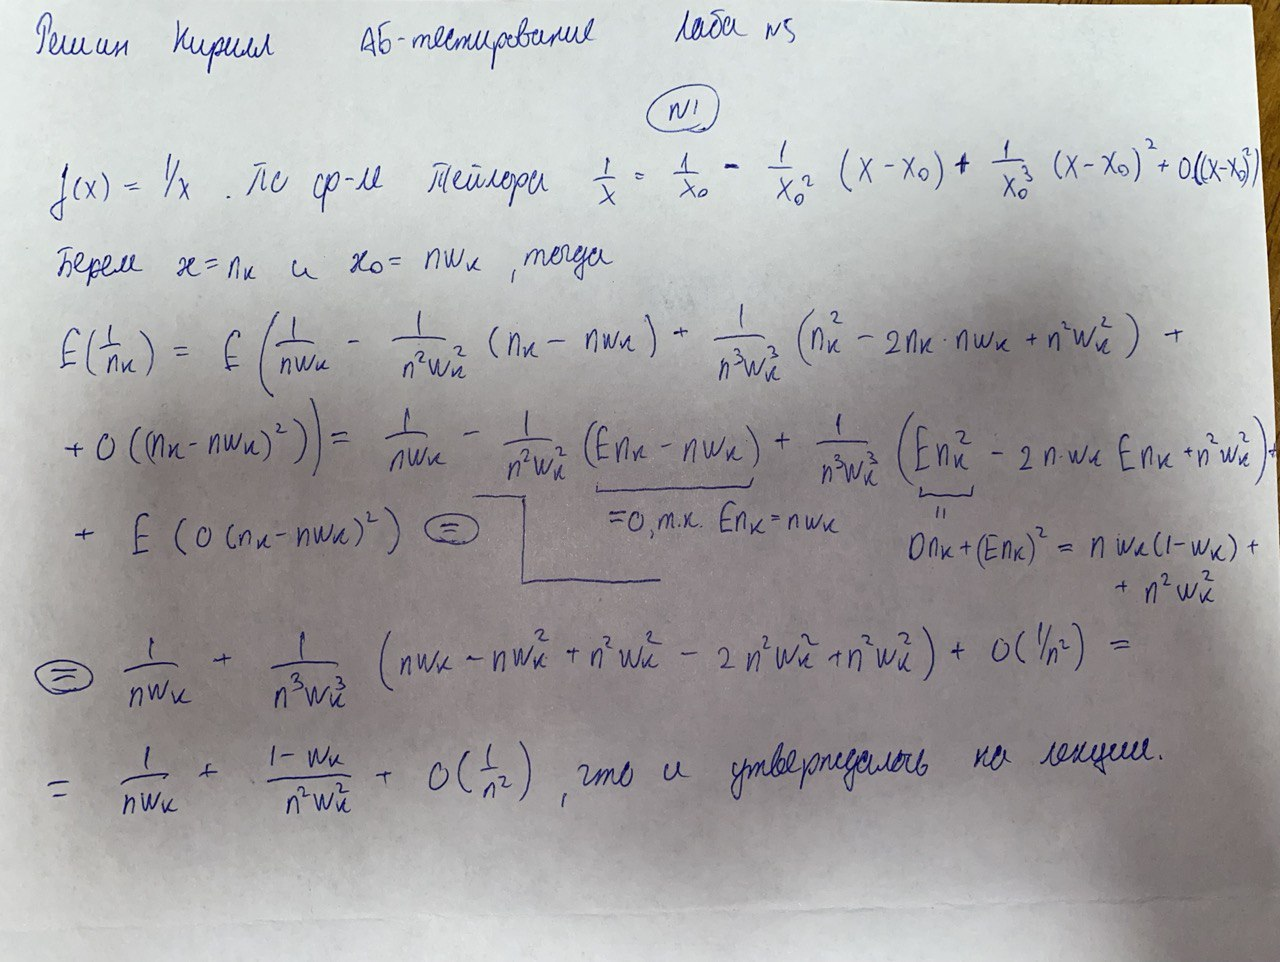

---
### Задача 2

Рассмотренные нами методы стратификации работают в случае стратифицированного семплирования, либо же случайного семплирования. Во втором случае метод называется постстратификацией. Однако, как мы видели на занятии, при наличии сильных перекосов в соотношении между стратами вероятность ошибки 1 рода может сильно увеличиваться.

Промоделируйте распределение разности 
* обычного среднего
* стратифицированного среднего

при наличии сильных перекосов в соотношении между стратами и проинтерпретируйте результаты.

Код для семплирования перекошенных данных и для семплирования разности средних есть в ноутбуке с занятия.

In [9]:
total_size = 10_000  # Общее количество объектов в данных
sample_size = 200  # Размер выборки
n_iter = 50_000  # Количество итераций семплирования

lw = 5  # Толщина линий на графиках

In [10]:
# Генерируем данные как на лекции

def generate_data(size, p=0.6, shift=5, scale_factor=1):
    '''
    Генерация общего объема данных.
    
    :param size: размер данных
    :param p: вероятность 1-й страты
    :param shift: смещение 1-й страты
    :param scale_factor: множитель масштаба 1-й страты
    :return: сгенерированные данные
    '''
    
    data = pd.DataFrame()
    data['strata'] = sps.bernoulli(p=p).rvs(size=size)
    data['sample'] = sps.norm.rvs(size=size) * (1 + scale_factor * data['strata']) \
                        + shift*data['strata']
    return data

In [11]:
# Генерируем перекошенные данные

data = generate_data(total_size)
data.head()

,strata,sample
0,0,-0.944468
1,1,4.109097
2,0,0.557245
3,1,7.159588
4,1,2.688516


In [12]:
def calculate_strata_weights(data):
    '''
    Вычисляет веса страт.
    
    :param data: исходные данные
    :return: веса страт
    '''
    
    strata_weights = data.groupby(by='strata')['sample'].count()
    strata_weights = strata_weights / strata_weights.sum()
    return strata_weights

strata_weights = calculate_strata_weights(data)
strata_weights

strata
0    0.4033
1    0.5967
Name: sample, dtype: float64

In [13]:
# Взвешенное семплирование с заданными весами, будем выставлять перекошенные веса

def weighted_sampler(data, sample_size, strata_weights='default'):
    '''
    Семплирование выборок по стратам с заданными весами.
    
    :param data: исходные данные
    :param sample_size: размер выборок
    :param strata_weights: веса страт или же 'default' если их надо определить из данных
    :return: две выборки
    '''
    groupped = data.groupby(by='strata')

    if strata_weights == 'default':
        # Веса страт определяем по данным
        strata_weights = groupped['sample'].count()
        strata_weights = strata_weights / strata_weights.sum()
    else:
        # Веса страт заданы
        strata_weights = np.array(strata_weights)

    # Размер выборок по стратам
    strata_sample_size = np.floor(sample_size * strata_weights + 0.5).astype(int)

    a_group, b_group = [], []
    # Генерируем отдельно из каждой страты
    for i, strata in enumerate(groupped):
        a, b = random_sampler(strata[1], strata_sample_size[i])
        a_group.append(a)
        b_group.append(b)

    return pd.concat(a_group), pd.concat(b_group)

In [14]:
def weighted_mean(data, weights):
    '''
    Вычисляет взвешенное среднее.
    
    :param data: данные
    :param weights: веса страт
    :return: взвешенное среднее
    '''
    
    strata_means = data.groupby(by='strata')['sample'].mean()
    return (strata_means * weights).sum()


def simple_mean(data, weights):
    '''
    Вычисляет обычное выборочное среднее
    
    :param data: данные
    :param weights: не используется, нужен для совместимости
    :return: выборочное среднее
    '''
    
    return data['sample'].mean()


def sample_mean_diff(sampler, mean_function, data, sample_size, n_iter, weights):
    '''
    Реализация итераций семплирования двух групп и вычисления разности средних.
    
    :param sampler: функция семплирования двух групп
    :param mean_function: функция вычисления среднего
    :param data: исходные данные
    :param sample_size: размер группы
    :param n_iter: количество итераций семплирования
    :return: выборка разности средних
    '''
    
    strata_weights = data.groupby(by='strata')['sample'].count()
    strata_weights = strata_weights / strata_weights.sum()

    mean_sample = np.zeros(n_iter)

    for i in tqdm(range(n_iter)):
        groups = sampler(data, sample_size, weights)
        mean_sample[i] = mean_function(groups[0], strata_weights) - mean_function(groups[1], strata_weights)

    return mean_sample

In [15]:
weights = [0.1, 0.9]

In [16]:
means_simple = sample_mean_diff(weighted_sampler, simple_mean, data, sample_size, n_iter, weights)
means_weighted = sample_mean_diff(weighted_sampler, weighted_mean, data, sample_size, n_iter, weights)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:53<00:00, 288.24it/s]


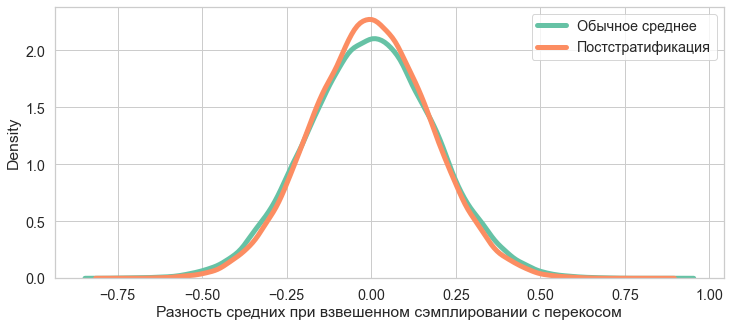

In [17]:
labels = [
    'Обычное среднее',
    'Постстратификация',
]

plt.figure(figsize=(12, 5))
sns.kdeplot(means_simple, lw=lw, label=labels[0])
sns.kdeplot(means_weighted, lw=lw, label=labels[1])
plt.xlabel('Разность средних при взвешенном сэмплировании с перекосом')
plt.legend();

In [18]:
weights = [0.7, 0.3]

In [19]:
means_simple = sample_mean_diff(weighted_sampler, simple_mean, data, sample_size, n_iter, weights)
means_weighted = sample_mean_diff(weighted_sampler, weighted_mean, data, sample_size, n_iter, weights)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:59<00:00, 277.78it/s]


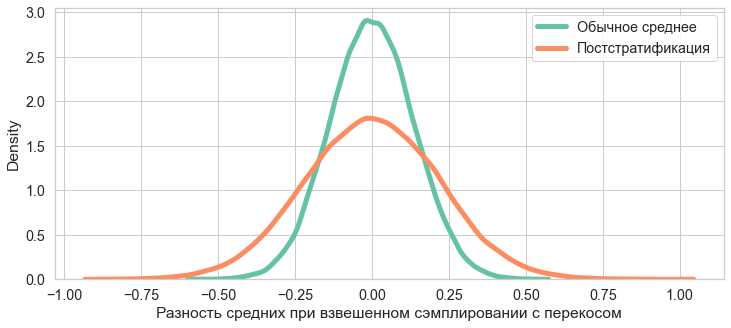

In [20]:
labels = [
    'Обычное среднее',
    'Постстратификация',
]

plt.figure(figsize=(12, 5))
sns.kdeplot(means_simple, lw=lw, label=labels[0])
sns.kdeplot(means_weighted, lw=lw, label=labels[1])
plt.xlabel('Разность средних при взвешенном сэмплировании с перекосом')
plt.legend();

В чем же тогда проблема того, что стратифицированный t-test увеличивает вероятность ошибки 1 рода?

Неправильно оценивается дисперсия

Можно ли как-то исправить его с помощью некоторой универсальной статистической процедуры?

В целом, можно тогда использовать бутстреп, чтобы правильно оценить дисперсию

Реализуйте эту процедруру.

In [84]:
n_iter = 5_000

In [87]:
def simple_var(data, strata_weights):
    '''
    Вычисляет обычную дисперсию при случайном семплировании.
    
    :param data: данные
    :param strata_weights: веса страт, не используется, нужен для совместимости
    :return: дисперсия
    '''
    
    return data['sample'].var() / len(data)

In [92]:
def stratified_test_boot(x_data, y_data, strata_weights, method='common', alpha=0.05):
    '''
    Стратифицированный абсолютный t-test.
    
    :param x_data: выборка вместе с информацией о стратах
    :param y_data: выборка вместе с информацией о стратах
    :param strata_weights: веса страт
    :param method: метод 'random', 'stratified', 'post_stratified'
    :param alpha: уровень значимости
    :return: статистика критерия, границы доверительного интервала, p-value
    '''
    
    if method == 'common':
        mean_function = simple_mean
        var_function = simple_var
        x_var  =  var_function(x_data, strata_weights)
        y_var  =  var_function(y_data, strata_weights)
        std = np.sqrt(x_var + y_var)
    else:
        mean_function = weighted_mean
        
        B = 200
        stats = []
        for i in range(B):
            indices = np.random.choice(np.arange(0, len(x_data), 1), len(x_data))
            stats.append(mean_function(x_data.iloc[indices], strata_weights) - \
                         mean_function(y_data.iloc[indices], strata_weights))
        std = np.std(stats)
        
    x_mean = mean_function(x_data, strata_weights)
    y_mean = mean_function(y_data, strata_weights)

    stat = x_mean - y_mean
    
    t_stat = stat / std
    pvalue = 2*sps.norm.sf(np.abs(t_stat))
    
    q = sps.norm.ppf(1 - alpha/2)
    left_bound = stat - q*std
    right_bound = stat + q*std
    
    return stat, left_bound, right_bound, pvalue

Провалидируйте полученный тест, а также сравните его по мощности со стандартным t-test. Используйте код с занятий.

In [89]:
def draw_interval(
    real_alpha, left_alpha, right_alpha, methods,
    alpha=0.05, figsize=(7, 2)
):
    '''
    Отрисовка интервала для реального уровня значимости
    real_alpha -- оценка уровня значимости
    left_alpha, right_alpha -- границы доверительного интервала
    methods --- список методов
    alpha -- теоретический уровень значимости
    figsize -- размер фигуры matplotlib
    '''
    
    texts = []
    
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(10, 3))
        
        for i in range(len(methods)):
            plt.hlines(-i, 0, 1, color='black', lw=2, alpha=0.6)
            plt.fill_between(
                [left_alpha[i], right_alpha[i]], [-i-0.25]*2, [-i+0.25]*2,
                color='green', alpha=0.6
            )
            plt.scatter(real_alpha[i], -i, s=300, marker='*', color='red')
            plt.xlim((min(alpha, left_alpha.min())-1e-3, max(alpha, right_alpha.max())+1e-3))
            texts.append(
                f'{methods[i]}\n'
                f'Доля отвержений = {100*real_alpha[i]:.2f}%,\n'
                f'интервал ({100*left_alpha[i]:.2f}%, {100*right_alpha[i]:.2f}%)'
            )
        plt.ylim((-len(methods)+0.65, 0.35))
        
        plt.vlines(alpha, -len(methods), 1, color='red', lw=5, linestyle='--', alpha=0.6)
        plt.yticks(-np.arange(len(methods)), texts)
        plt.tight_layout()
        plt.show()
        
def calculate_real_alpha(n_errors, n_iter):
    '''
    Оценка реального уровня значимости и его дов. интервала.
    
    Аргументы:
    n_errors -- количество ошибок в эксперименте
    n_iter -- количество экспериментов
    
    Возвращает:
    real_alpha -- оценка реального уровня значимости
    left_alpha, right_alpha -- границы соотв. дов. интервала
    '''
    
    real_alpha = n_errors / n_iter
    left_alpha, right_alpha = proportion_confint(n_errors, n_iter, method='wilson')
    
    return real_alpha, left_alpha, right_alpha

In [90]:
def AA_test(
    generate_data, sampler, total_size=20000,
    methods=['common', 'post_stratified'],
    n_iter=10000, sample_size=200, alpha=0.05, effect=0, show=True
):
    '''
    Проведение серии AA-тестов на искусственных выборках.
    
    Аргументы:
    generate_data -- функция для семплирования исходных данных
    sampler -- функция для семплирования групп
    total_size -- общий размер данных
    methods -- список методов из 'random', 'stratified', 'post_stratified'
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    effect -- величина эффекта
    show -- строить ли график
    '''

    n_errors = np.zeros(len(methods))  # количество отвержений H_0

    # Проведение экспериментов
    for _ in tqdm(range(n_iter)):
        data = generate_data(total_size)
        strata_weights = calculate_strata_weights(data)
        x, y = sampler(data, sample_size)
        y['sample'] += effect
        
        for i in range(len(methods)):
            n_errors[i] += stratified_test_boot(x, y, strata_weights, method=methods[i])[-1] < alpha

    if show:
        # Реальный уровень значимости
        real_alphas = np.zeros((len(methods), 3))
        for i in range(len(methods)):
            real_alphas[i] = calculate_real_alpha(n_errors[i], n_iter)
        draw_interval(
            real_alphas[:, 0], real_alphas[:, 1], real_alphas[:, 2], 
            methods, alpha=alpha
        )
        
    return n_errors / n_iter

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [34:26<00:00,  2.42it/s]


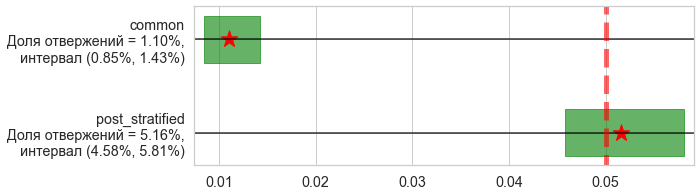

In [93]:
AA_test(
    generate_data, 
    lambda data, sample_size: weighted_sampler(data, sample_size, strata_weights=[0.1, 0.9]), 
    n_iter=n_iter
);

In [ ]:
# Отлично, видим, что все починилось, так как теперь дисперсия оценивается верно с помощью бутстрепа (в случае постстратификации)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [34:22<00:00,  2.42it/s]


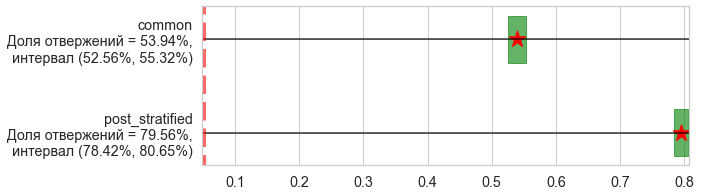

In [94]:
AA_test(
    generate_data, 
    lambda data, sample_size: weighted_sampler(data, sample_size, strata_weights=[0.1, 0.9]), 
    n_iter=n_iter,
    effect = 0.5
);

In [ ]:
# Итого мощность выше после стратификации, все супер

---
### Задача 3

Со слов менеджера по развитию интернет-магазина:

> Коллеги, приветики! В прошлом месяце мы проводили эксперимент, в корзине покупателей поставили большую мигающую кнопку "Оплатить" ярко-зеленого цвета. Предполагаем, что покупатель будет быстрее переходить к оплате, не удаляя из корзины лишние товары. Ожидаем прирост выручки на 8-10%. Помогите, пожалуйста, по-скорее оценить эффект, очень горят сроки, скоро выплаты премий, надо успеть раскатить. В файлике инфа по клиентам, пилотные клиенты отмечены в столбце `b_group`. Спасибо огромное!

Помогите коллегам с их запросом.

In [21]:
X = pd.read_excel('hw_ab5_task3.xlsx')

In [32]:
X.b_group.value_counts()

no     27000
yes     3000
Name: b_group, dtype: int64

In [ ]:
# Еще на лекции обсуждали, что операционная система - хорошая страта

In [39]:
pilot = pd.DataFrame()
pilot['strata'] = X[X.b_group == 'yes']['OS'].apply(lambda x: 0 if x == 'Android' else 1)
pilot['sample'] = X[X.b_group == 'yes']['month18'] # Эксперимент же пробоводился последний месяц, значит его и берем
print(len(pilot))
pilot.head()

3000


,strata,sample
1,0,0.000000
3,0,866.403692
11,1,2374.211176
17,0,1261.616492
19,1,4680.684911


In [40]:
not_pilot = pd.DataFrame()
not_pilot['strata'] = X[X.b_group == 'no']['OS'].apply(lambda x: 0 if x == 'Android' else 1)
not_pilot['sample'] = X[X.b_group == 'no']['month18'] # Эксперимент же пробоводился последний месяц, значит его и берем
print(len(not_pilot))
not_pilot.head()

27000


,strata,sample
0,0,0.000000
2,1,1483.007220
4,1,2035.514926
5,1,2031.262214
6,1,970.468855


In [49]:
# Веса страт

strata_weights = X.groupby(by='OS')['month18'].count()
strata_weights = strata_weights / strata_weights.sum()
strata_weights

OS
Android    0.7291
iOS        0.2709
Name: month18, dtype: float64

Раз тест уже проведен, то все параметры фиксированы. То есть n = 3000, alpha и beta не были уточнены (скорее всего 5% и 80%). Это означает, что нам нужно посчитать значение статистики на полученных данных, построить доверительный интервал и посчитать p-value. Статистика, как в относительном t-test'e: x.mean()/y.mean() - 1, только в этом случае будем использовать стратифицированное среднее, так как есть страты. Дисперсию будем считать по постстратифицированному методу (видимо изначально стратификация не подразумевалась)

In [43]:
def weighted_mean(data, weights):
    '''
    Вычисляет взвешенное среднее.
    
    :param data: данные
    :param weights: веса страт
    :return: взвешенное среднее
    '''
    
    strata_means = data.groupby(by='strata')['sample'].mean()
    return (strata_means * weights).sum()

In [44]:
# Видимо у нас постстратификация, так что используем такой метод

def weighted_post_var(data, strata_weights):
    '''
    Вычисляет взвешенную дисперсию при постстратификации.
    
    :param data: данные
    :param strata_weights: веса страт
    :return: дисперсия
    '''
    
    strata_vars = data.groupby(by='strata')['sample'].var()
    weighted_var = (strata_vars * strata_weights).sum() / len(data)
    post_addition = (strata_vars * (1-strata_weights)).sum() / (len(data)**2)
    return weighted_var + post_addition

In [58]:
x_mean = weighted_mean(pilot, np.array(strata_weights))
y_mean = weighted_mean(not_pilot, np.array(strata_weights))
x_var  =  weighted_post_var(pilot, np.array(strata_weights))
y_var  =  weighted_post_var(not_pilot, np.array(strata_weights))
    
stat = x_mean / y_mean - 1
std = np.sqrt(x_var / y_mean ** 2 + y_var * x_mean ** 2 / y_mean ** 4)

t_stat = np.sqrt(len(pilot)) * stat / std
print(t_stat)
pvalue = 2*sps.norm.sf(np.abs(t_stat)) # При нулевой гипотезе было бы стандартное нормальное распределение 
    
q = sps.norm.ppf(1 - 0.05/2)
left_bound = stat - q*std
right_bound = stat + q*std
stat, (left_bound, right_bound), pvalue

278.94950855356774


(0.11846683176961359, (0.07287575056083317, 0.164057912978394), 0.0)

Значит, видимо, можно отбросить нулевую гипотезу о том, что эффекта нет, то есть можно выкатывать фичу

Помимо статистической значимости следует также учитывать размер эффекта. Величина эффекта получилась на уровне, сказанном в тексте, то есть результат заслуживает внимания